/Users/antontravkin/Sites/python_rtk/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END rf_models__criterion=gini, rf_models__max_depth=5, rf_models__max_features=log2, rf_models__min_samples_leaf=7, rf_models__min_samples_split=5, rf_models__n_estimators=100; total time=   0.5s
[CV] END rf_models__criterion=gini, rf_models__max_depth=5, rf_models__max_features=log2, rf_models__min_samples_leaf=7, rf_models__min_samples_split=5, rf_models__n_estimators=100; total time=   0.5s
[CV] END rf_models__criterion=gini, rf_models__max_depth=5, rf_models__max_features=log2, rf_models__min_samples_leaf=7, rf_models__min_samples_split=5, rf_models__n_estimators=100; total time=   0.5s
[CV] END rf_models__criterion=gini, rf_models__max_depth=5, rf_models__max_features=log2, rf_models__min_samples_leaf=7, rf_models__min_samples_split=5, rf_models__n_estimators=100; total time=   0.5s
[CV] END rf_models__criterion=gini, rf_models__max_depth=5, rf_models__max_features=log2, rf_models__min_samples_leaf=7, rf_models__mi

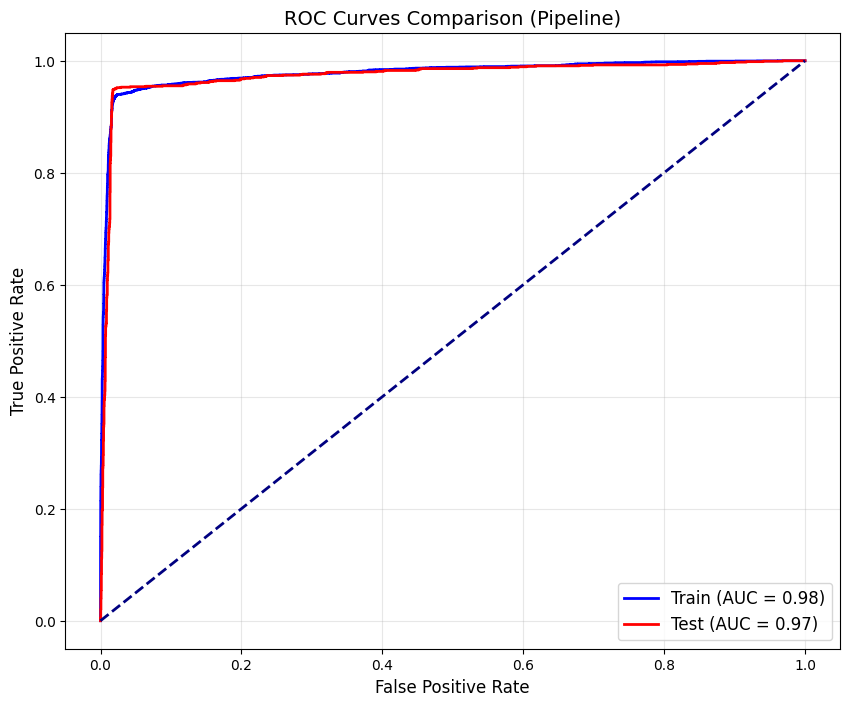

Оптимальный порог: 0.670


/Users/antontravkin/Sites/python_rtk/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/antontravkin/Sites/python_rtk/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/antontravkin/Sites/python_rtk/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/antontravkin/Sites/python_rtk/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/antontravkin/Sites/python_rtk/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature

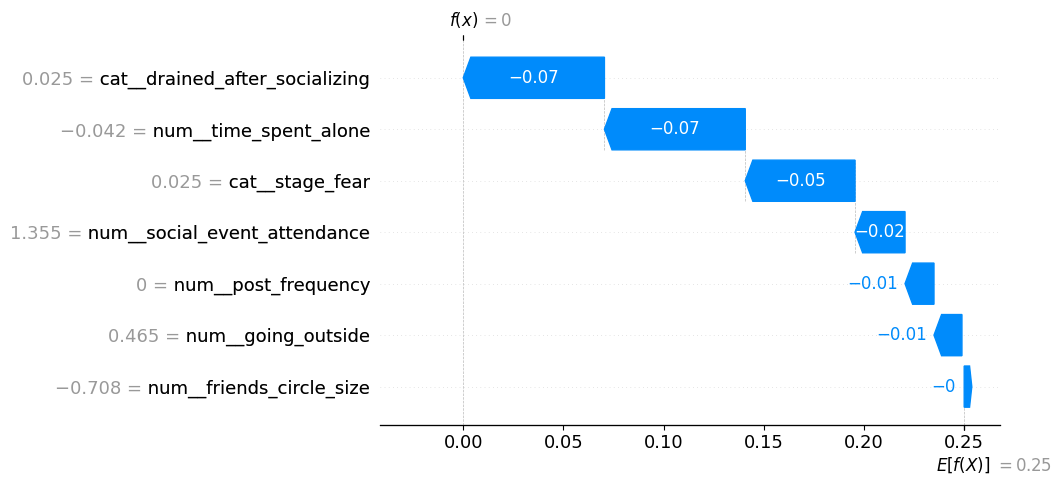

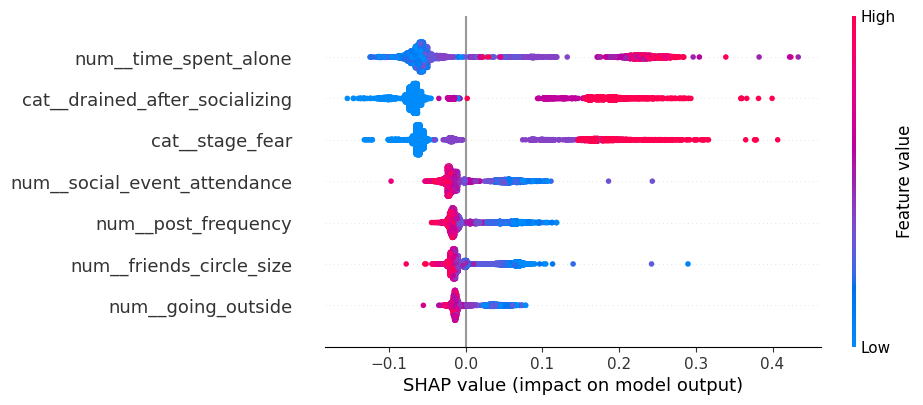

✅ Файл для отправки создан: submission.csv
100%|███████████████████████████████████████| 96.5k/96.5k [00:00<00:00, 147kB/s]
Successfully submitted to Predict the Introverts from the ExtrovertsPipeline сохранен в файл 'pipeline_best_model.pkl'.
Pipeline загружен.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import zipfile
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# === Установка начального значения для генератора случайных чисел
rng = np.random.default_rng(42)

# === Функция для вычисления метрик и построения ROC-кривых с оптимизацией порога
def calculate_metrics_and_plot_roc_comparison(model, X_train, y_train, X_test, y_test):
    """
    Рассчитывает метрики классификации и строит ROC-кривые с оптимизацией порога.
    """
    # Оптимизация порога по F1
    y_proba_test = model.predict_proba(X_test)[:, 1]
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = [f1_score(y_test, (y_proba_test >= thr).astype(int)) for thr in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]

    results = {}
    for X, y, sample_type in [(X_train, y_train, "train"), (X_test, y_test, "test")]:
        y_proba = model.predict_proba(X)[:, 1]
        y_pred = (y_proba >= best_threshold).astype(int)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_proba)
        fpr, tpr, _ = roc_curve(y, y_proba)
        results[sample_type] = {
            'precision': precision,
            'recall': recall,
            'roc_auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
            'threshold': best_threshold
        }

    # Построение ROC-кривых
    plt.figure(figsize=(10, 8))
    colors = {'train': 'blue', 'test': 'red'}
    for sample_type in ['train', 'test']:
        plt.plot(
            results[sample_type]['fpr'],
            results[sample_type]['tpr'],
            color=colors[sample_type],
            lw=2,
            label=f'{sample_type.capitalize()} (AUC = {results[sample_type]["roc_auc"]:.2f})'
        )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves Comparison ({type(model).__name__})', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Оптимальный порог: {best_threshold:.3f}")
    return results, best_threshold

# === Загрузка данных
def load_dataset(from_kaggle=False):
    """Загружает датасет из zip-архива."""
    zip_ref = zipfile.ZipFile('playground-series-s5e7.zip', 'r')
    zip_ref.extractall()
    zip_ref.close()
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    df_sample_submission = pd.read_csv('sample_submission.csv')
    return df_train, df_test, df_sample_submission

df_train, df_test, df_sample_submission = load_dataset(from_kaggle=False)

# === Переименование столбцов
df_train.columns = [col.lower().replace("(", "_").replace(")", "").replace(" ", "_") for col in df_train.columns]
df_test.columns = [col.lower().replace("(", "_").replace(")", "").replace(" ", "_") for col in df_test.columns]

# === Обработка целевой переменной
target = 'personality'
dict_personality = {'Extrovert': 0, 'Introvert': 1}
dict_personality_rev = {0: 'Extrovert', 1: 'Introvert'}
df_train['int_personality'] = df_train[target].map(dict_personality)

# === Определение признаков
id_features = ['id']
exclude_features = ['personality']
num_features = [col for col in df_train.select_dtypes(include='number').columns
                if col not in id_features + ['int_personality'] + exclude_features]
cat_features = [col for col in df_train.select_dtypes(exclude='number').columns
                if col not in id_features + ['int_personality'] + exclude_features]

# === Предобработка данных
cat_pipe = Pipeline([
    ('enc', TargetEncoder(cols=cat_features)),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])
num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))
])
data_preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_features),
    ('num', num_pipe, num_features)
])

# === Разделение данных
X = df_train[num_features + cat_features]
y = df_train['int_personality']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.75, random_state=42)

# === Преобразование данных
X_train_p = pd.DataFrame(data_preprocessor.fit_transform(X_train, y_train), columns=data_preprocessor.get_feature_names_out())
X_test_p = pd.DataFrame(data_preprocessor.transform(X_test), columns=data_preprocessor.get_feature_names_out())

# === Модель RandomForest
rf_cl = Pipeline([
    ('preprocessor', data_preprocessor),
    ('rf_models', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# === Оптимизация гиперпараметров
param_grid = {
    'rf_models__n_estimators': [100, 300],
    'rf_models__criterion': ['gini'],
    'rf_models__max_depth': [5, 7, 10],
    'rf_models__min_samples_split': [5, 10],
    'rf_models__min_samples_leaf': [7, 10],
    'rf_models__max_features': ['log2']
}
grid_search = GridSearchCV(rf_cl, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Лучшие параметры:", grid_search.best_params_)


best_rf_model = grid_search.best_estimator_

# === Метрики и ROC-кривые
res_rf, best_threshold = calculate_metrics_and_plot_roc_comparison(best_rf_model, X_train, y_train, X_test, y_test)

# === SHAP-анализ
np.random.seed(42)  # Глобальное семя для воспроизводимости
explainer_tree = shap.Explainer(best_rf_model.steps[1][1].predict, X_test_p)
shap_values_tree = explainer_tree(X_test_p)
shap.plots.waterfall(shap_values_tree[0], max_display=14)
shap.plots.beeswarm(shap_values_tree)

# === Предсказание и сохранение
X_test_full = df_test[num_features + cat_features]
df_test_p = pd.DataFrame(data_preprocessor.transform(X_test_full), columns=data_preprocessor.get_feature_names_out())
df_test['pred'] = best_rf_model.predict(X_test_full)
df_test['Personality'] = df_test['pred'].map(dict_personality_rev)
df_test[['id', 'Personality']].to_csv('submission.csv', index=False)
print("✅ Файл для отправки создан: submission.csv")

# === Отправка на Kaggle
!kaggle competitions submit -c playground-series-s5e7 -f submission.csv -m "Submission from 12:44 PM EDT, July 18, 2025"

# === Сохранение модели
import pickle
with open('pipeline_best_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)
print("Pipeline сохранен в файл 'pipeline_best_model.pkl'.")

# === Загрузка модели (для проверки)
with open('pipeline_best_model.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)
print("Pipeline загружен.")